# Section B

In [3]:
#importing required modules and dependencies
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pickle

# 1) Scratch Implementation

In [ ]:
class NeuralNetwork:
    #attributes
    N: int #number of hidden layers in network
    A: np.ndarray | list[int] #list (size=N) specifying number of neurons in each hidden layer
    lr: float #learning rate
    epochs: int #number of epochs/iterations
    batch_size: int #batch size for gradient descent

    #initialize the neural network object
    def __init__(self, N, A, lr, activation, activation_grad, weight_init, epochs, batch_size):
        self.N = N
        assert len(A) == self.N, f"number of neurons must be specified for each hidden layer{len(A)}"
        self.A = A.copy()
        self.lr = lr
        self.activation = activation #activation function
        self.activation_grad = activation_grad #gradient of activation function
        self.weight_init = weight_init #weight initialization function
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights = []
        self.biases = []
        self.activations = []
        self.train_loss = []
        self.val_loss = []

    #computes softmax for last layer
    @staticmethod
    def _softmax(x):
        # return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
        #normalize x to avoid overflow by subtracting the max value from each row
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)

    #returns probability of each class which is output of last layer of neural network
    def forward_propagation(self, X):
        self.activations[0] = X
        #forward pass through each layer
        for i in range(self.N - 1):
            X_temp = np.dot(self.activations[i], self.weights[i]) + self.biases[i]
            if i == self.N - 2:
                X_activ = self._softmax(X_temp) #softmax for output layer
            else:
                X_activ = self.activation(X_temp) #activation function for hidden layers
            self.activations[i+1] = X_activ
        return X_activ

    #compute and update gradients of weights and biases and errors for next layer
    def backward_propagation(self, X, y, output):
        error = (output - y) / X.shape[0] #fix error term dimensions
        for i in range(self.N - 2, -1, -1):
            #compute gradients
            dw = np.dot(self.activations[i].T, error)
            db = np.sum(error, axis=0, keepdims=True)
            #update weight and bias
            self.weights[i] -= self.lr * dw
            self.biases[i] -= self.lr * db
            #compute error for next layer
            error = np.dot(error, self.weights[i].T) * self.activation_grad(self.activations[i])
        return error

    #train model on input data X and labels Y
    def fit(self, X, y, X_val, y_val, early_stopping=True, patience=5):
        #add number of neurons in input and output layer
        self.A.insert(0, X.shape[1])
        self.A.append(y.shape[1])
        self.N += 2 #update number of layers
        #initialize weights and biases
        for i in range(len(self.A)-1):
            self.weights.append(self.weight_init((self.A[i], self.A[i+1])))
            self.biases.append(self.weight_init((1,self.A[i+1])))
        #initialize activations
        self.activations = [X] + [np.zeros(shape) for shape in self.A[1:]]
        #variables for early stopping
        best_val_loss = float('inf')
        best_weights = None
        best_biases = None
        patience_counter = 0

        #train over epochs
        for epoch in range(self.epochs):
            for i in range(0, X.shape[0], self.batch_size):
                X_batch = X[i: min(i+self.batch_size, X.shape[0])]
                y_batch = y[i: min(i+self.batch_size, X.shape[0])]
                #forward pass
                y_pred = self.forward_propagation(X_batch)
                #backward pass
                self.backward_propagation(X_batch, y_batch, y_pred)
            #compute and append losses
            y_pred_train = self.forward_propagation(X)
            epoch_train_loss = -np.sum(y * np.log(y_pred_train + 1e-6)) / y.shape[0]
            y_pred_val = self.forward_propagation(X_val)
            epoch_val_loss = -np.sum(y_val * np.log(y_pred_val + 1e-6)) / y_val.shape[0]
            self.train_loss.append(epoch_train_loss)
            self.val_loss.append(epoch_val_loss)
            if early_stopping:
                #check for early stopping
                if epoch_val_loss < best_val_loss:
                    best_val_loss = epoch_val_loss
                    best_weights = [w.copy() for w in self.weights]
                    best_biases = [b.copy() for b in self.biases]
                    patience_counter = 0
                else:
                    patience_counter += 1
                #stop training if losses are not decreasing for certain number (patience) of iterations
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    self.weights = best_weights
                    self.biases = best_biases
                    break

    #apply forward propagation
    def predict_prob(self, X):
        return self.forward_propagation(X) #get probabilities for each row in X

    #return predicted class for each row in X
    def predict(self, X):
        y_pred_prob = self.predict_prob(X) #get probabilities of each class
        #set highest probability to 1 and rest to 0
        y_pred = np.zeros_like(y_pred_prob)
        y_pred[np.arange(len(y_pred_prob)), y_pred_prob.argmax(1)] = 1
        return y_pred

    #compute accuracy of the model
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

    #plot loss vs epochs
    def plot_losses(self):
        plt.plot(self.train_loss, label='Training Loss')
        plt.plot(self.val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

# 2) Activation Functions and Gradients

In [5]:
#sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_grad(x):
    s = sigmoid(x)
    return s * (1 - s)

#tanh
def tanh(x):
    return np.tanh(x)
def tanh_grad(x):
    return 1 - np.tanh(x)**2

#relu
def relu(x):
    return np.where(x > 0, x, 0) #max(0, x)
def relu_grad(x):
    return np.where(x > 0, 1, 0)

#leaky relu
def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)
def leaky_relu_grad(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

#softmax
def softmax(x):
    # return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
    #normalize x to avoid overflow by subtracting the max value from each row
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)
def softmax_grad(x):
    s = softmax(x)
    return s * (1 - s)

# 3) Weight Initialization Functions

In [1]:
#zero initialization
def zero_init(shape):
    return np.zeros(shape)

#random initialization
def random_init(shape):
    # return np.random.uniform(-0.01, 0.01, shape)
    weights = np.random.random(shape)*2-1
    return weights/np.sqrt(np.sum(weights**2)) #scale weights

#normal initialization
def normal_init(shape):
    weights = np.random.normal(0, 1, shape)
    return weights/np.sqrt(np.sum(weights**2)) #scale weights

# 4) Data Processing and Model Training

Load dataset and visualize few images. Perform appropriate preprocessing and split dataset.

Training set shape: (60000, 28, 28)
Testing set shape: (10000, 28, 28)


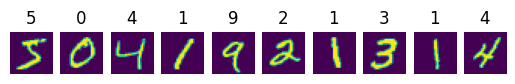

In [7]:
#load MNIST dataset
with np.load('mnist.npz') as f:
    X_train, X_test, y_train, y_test = f['x_train'], f['x_test'], f['y_train'], f['y_test']

print('Training set shape:', X_train.shape)
print('Testing set shape:', X_test.shape)

#visualise a few images from training set
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    plt.title(f"{y_train[i]}")
    plt.axis('off')
plt.show()

In [8]:
#data pre-processing and splitting
#flatten images from 28x28 matrix to 1D array
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
#normalize images bringing values to the range [0,1]
X_train = X_train/255.0
X_test = X_test/255.0

#convert labels to one-hot encoded vectors (for output layer neurons)
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1,1)).toarray()
y_test = encoder.transform(y_test.reshape(-1,1)).toarray()

#we already have a testing set, so we split training set as 80:20 (train:validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print('training set size:', len(y_train))
print('validation set size:', len(y_val))
print('testing set size:', len(y_test))

#define given configuration
N = 4
A = [256, 128, 64, 32]
epochs = 100
batch_size = 128
lr = 2e-3

training set size: 48000
validation set size: 12000
testing set size: 10000


Train models with all combinations of activation functions and weight initialization functions.  
  
- Activation functions: sigmoid, tanh, ReLU, Leaky ReLU  
- Weight initialization functions: zero init, random init, normal init

Early stopping at epoch 8
Metrics for model with sigmoid activation function and zero weight initialization:
Training accuracy: 0.8225833333333333
Validation accuracy: 0.8220333333333333
Test accuracy: 0.8227


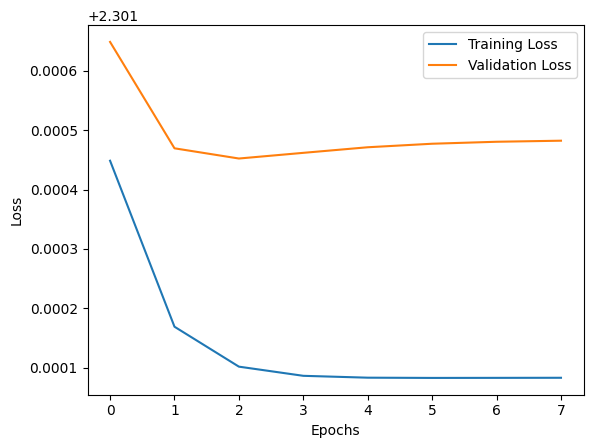

In [7]:
model_sigmoid_zero = NeuralNetwork(N, A, lr, sigmoid, sigmoid_grad, zero_init, epochs, batch_size)
model_sigmoid_zero.fit(X_train, y_train, X_val, y_val)

print("Metrics for model with sigmoid activation function and zero weight initialization:")
print("Training accuracy:", model_sigmoid_zero.score(X_train, y_train))
print("Validation accuracy:", model_sigmoid_zero.score(X_val, y_val))
print("Test accuracy:", model_sigmoid_zero.score(X_test, y_test))
model_sigmoid_zero.plot_losses()

Early stopping at epoch 9
Metrics for model with sigmoid activation function and random weight initialization:
Training accuracy: 0.8225833333333333
Validation accuracy: 0.8220333333333333
Test accuracy: 0.8227


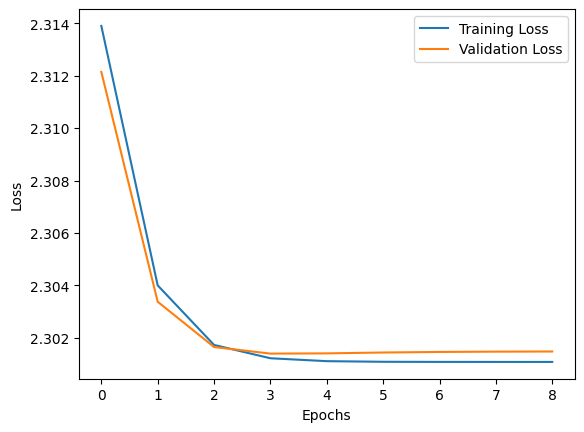

In [8]:
model_sigmoid_random = NeuralNetwork(N, A, lr, sigmoid, sigmoid_grad, random_init, epochs, batch_size)
model_sigmoid_random.fit(X_train, y_train, X_val, y_val)

print("Metrics for model with sigmoid activation function and random weight initialization:")
print("Training accuracy:", model_sigmoid_random.score(X_train, y_train))
print("Validation accuracy:", model_sigmoid_random.score(X_val, y_val))
print("Test accuracy:", model_sigmoid_random.score(X_test, y_test))
model_sigmoid_random.plot_losses()

Early stopping at epoch 14
Metrics for model with sigmoid activation function and normal weight initialization:
Training accuracy: 0.8225833333333333
Validation accuracy: 0.8220333333333333
Test accuracy: 0.8227


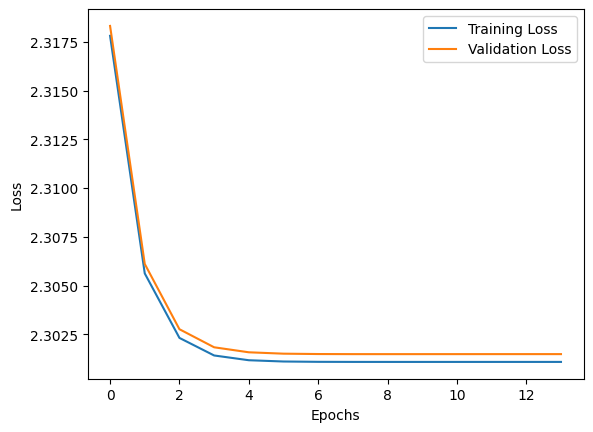

In [9]:
model_sigmoid_normal = NeuralNetwork(N, A, lr, sigmoid, sigmoid_grad, normal_init, epochs, batch_size)
model_sigmoid_normal.fit(X_train, y_train, X_val, y_val)

print("Metrics for model with sigmoid activation function and normal weight initialization:")
print("Training accuracy:", model_sigmoid_normal.score(X_train, y_train))
print("Validation accuracy:", model_sigmoid_normal.score(X_val, y_val))
print("Test accuracy:", model_sigmoid_normal.score(X_test, y_test))
model_sigmoid_normal.plot_losses()

Early stopping at epoch 32
Metrics for model with tanh activation function and zero weight initialization:
Training accuracy: 0.8225833333333333
Validation accuracy: 0.8220333333333333
Test accuracy: 0.8227


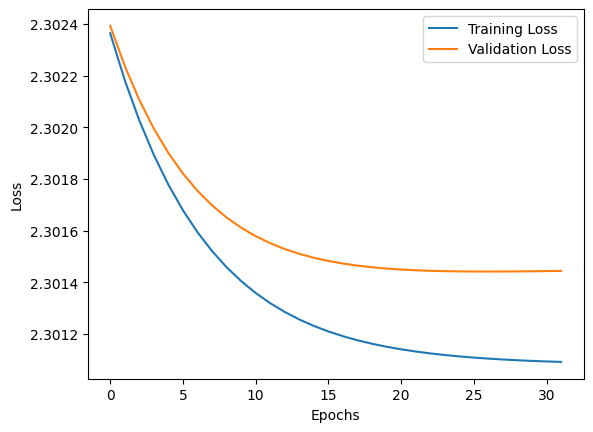

In [10]:
model_tanh_zero = NeuralNetwork(N, A, lr, tanh, tanh_grad, zero_init, epochs, batch_size)
model_tanh_zero.fit(X_train, y_train, X_val, y_val)

print("Metrics for model with tanh activation function and zero weight initialization:")
print("Training accuracy:", model_tanh_zero.score(X_train, y_train))
print("Validation accuracy:", model_tanh_zero.score(X_val, y_val))
print("Test accuracy:", model_tanh_zero.score(X_test, y_test))
model_tanh_zero.plot_losses()

Metrics for model with tanh activation function and random weight initialization:
Training accuracy: 0.8225833333333333
Validation accuracy: 0.8220333333333333
Test accuracy: 0.8227


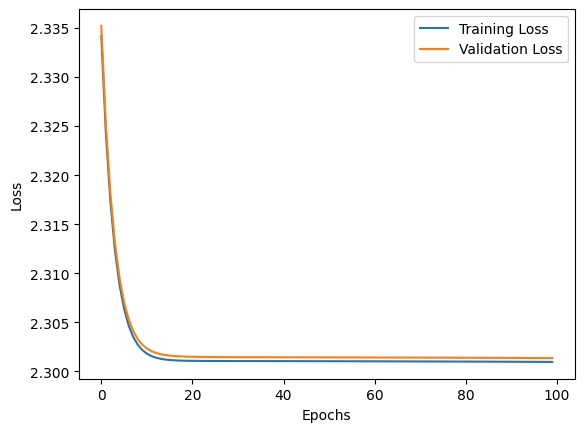

In [11]:
model_tanh_random = NeuralNetwork(N, A, lr, tanh, tanh_grad, random_init, epochs, batch_size)
model_tanh_random.fit(X_train, y_train, X_val, y_val)

print("Metrics for model with tanh activation function and random weight initialization:")
print("Training accuracy:", model_tanh_random.score(X_train, y_train))
print("Validation accuracy:", model_tanh_random.score(X_val, y_val))
print("Test accuracy:", model_tanh_random.score(X_test, y_test))
model_tanh_random.plot_losses()

Metrics for model with tanh activation function and normal weight initialization:
Training accuracy: 0.8225833333333333
Validation accuracy: 0.8220333333333333
Test accuracy: 0.8227


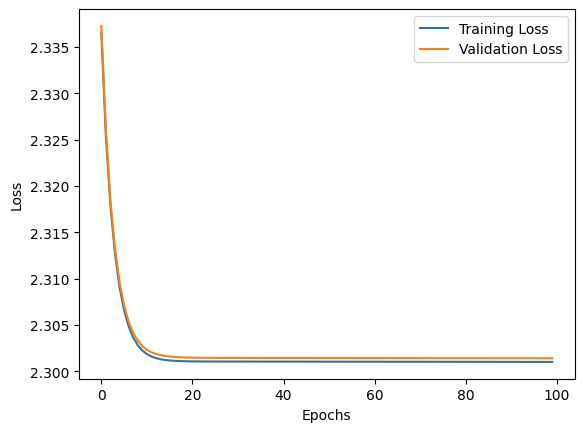

In [12]:
model_tanh_normal = NeuralNetwork(N, A, lr, tanh, tanh_grad, normal_init, epochs, batch_size)
model_tanh_normal.fit(X_train, y_train, X_val, y_val)

print("Metrics for model with tanh activation function and normal weight initialization:")
print("Training accuracy:", model_tanh_normal.score(X_train, y_train))
print("Validation accuracy:", model_tanh_normal.score(X_val, y_val))
print("Test accuracy:", model_tanh_normal.score(X_test, y_test))
model_tanh_normal.plot_losses()

Early stopping at epoch 32
Metrics for model with ReLU activation function and zero weight initialization:
Training accuracy: 0.8225833333333333
Validation accuracy: 0.8220333333333333
Test accuracy: 0.8227


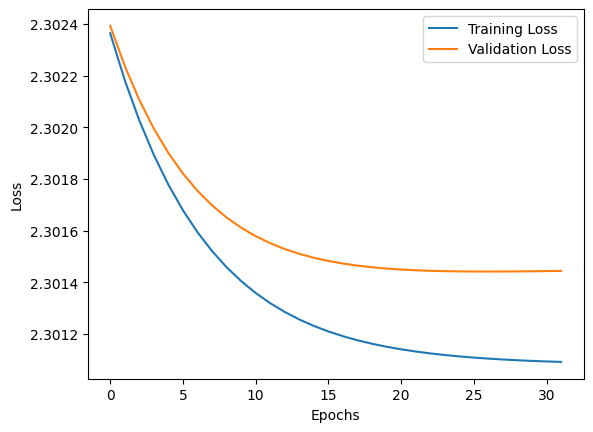

In [13]:
model_relu_zero = NeuralNetwork(N, A, lr, relu, relu_grad, zero_init, epochs, batch_size)
model_relu_zero.fit(X_train, y_train, X_val, y_val)

print("Metrics for model with ReLU activation function and zero weight initialization:")
print("Training accuracy:", model_relu_zero.score(X_train, y_train))
print("Validation accuracy:", model_relu_zero.score(X_val, y_val))
print("Test accuracy:", model_relu_zero.score(X_test, y_test))
model_relu_zero.plot_losses()

Metrics for model with ReLU activation function and random weight initialization:
Training accuracy: 0.8225833333333333
Validation accuracy: 0.8220333333333333
Test accuracy: 0.8227


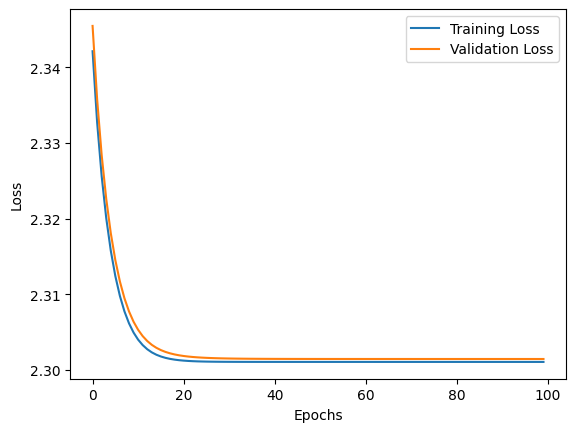

In [14]:
model_relu_random = NeuralNetwork(N, A, lr, relu, relu_grad, random_init, epochs, batch_size)
model_relu_random.fit(X_train, y_train, X_val, y_val)

print("Metrics for model with ReLU activation function and random weight initialization:")
print("Training accuracy:", model_relu_random.score(X_train, y_train))
print("Validation accuracy:", model_relu_random.score(X_val, y_val))
print("Test accuracy:", model_relu_random.score(X_test, y_test))
model_relu_random.plot_losses()

Metrics for model with ReLU activation function and normal weight initialization:
Training accuracy: 0.8225833333333333
Validation accuracy: 0.8220333333333333
Test accuracy: 0.8227


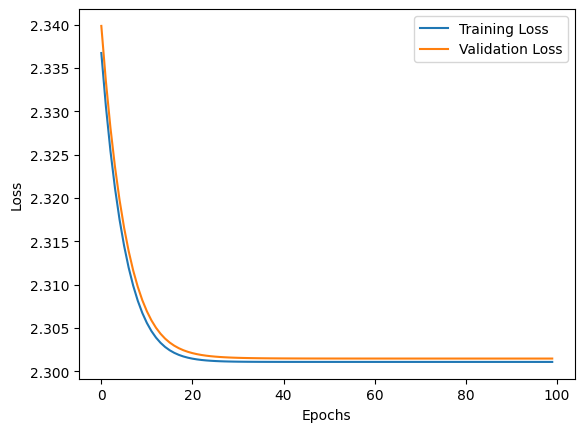

In [15]:
model_relu_normal = NeuralNetwork(N, A, lr, relu, relu_grad, normal_init, epochs, batch_size)
model_relu_normal.fit(X_train, y_train, X_val, y_val)

print("Metrics for model with ReLU activation function and normal weight initialization:")
print("Training accuracy:", model_relu_normal.score(X_train, y_train))
print("Validation accuracy:", model_relu_normal.score(X_val, y_val))
print("Test accuracy:", model_relu_normal.score(X_test, y_test))
model_relu_normal.plot_losses()

Early stopping at epoch 32
Metrics for model with Leaky ReLU activation function and zero weight initialization:
Training accuracy: 0.8225833333333333
Validation accuracy: 0.8220333333333333
Test accuracy: 0.8227


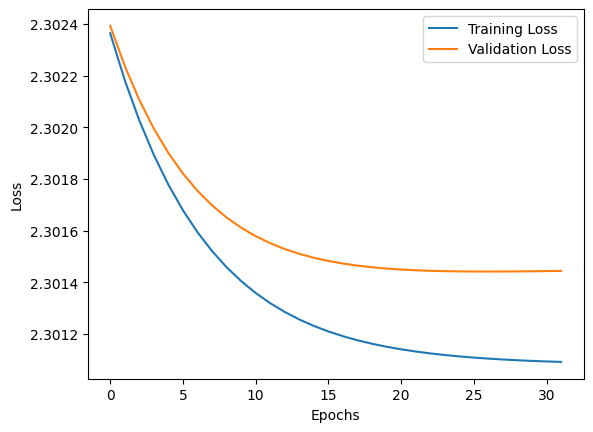

In [16]:
model_leaky_relu_zero = NeuralNetwork(N, A, lr, leaky_relu, leaky_relu_grad, zero_init, epochs, batch_size)
model_leaky_relu_zero.fit(X_train, y_train, X_val, y_val)

print("Metrics for model with Leaky ReLU activation function and zero weight initialization:")
print("Training accuracy:", model_leaky_relu_zero.score(X_train, y_train))
print("Validation accuracy:", model_leaky_relu_zero.score(X_val, y_val))
print("Test accuracy:", model_leaky_relu_zero.score(X_test, y_test))
model_leaky_relu_zero.plot_losses()

Early stopping at epoch 30
Metrics for model with Leaky ReLU activation function and random weight initialization:
Training accuracy: 0.8225833333333333
Validation accuracy: 0.8220333333333333
Test accuracy: 0.8227


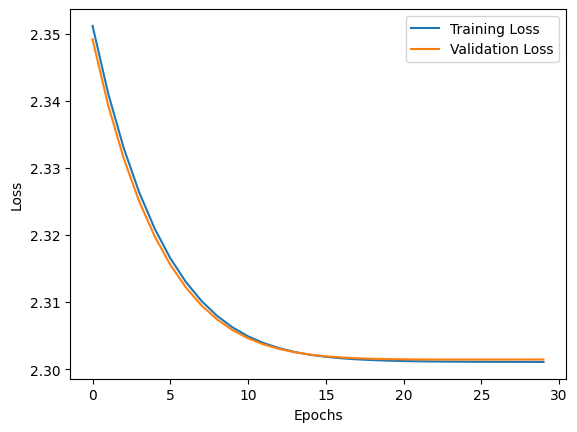

In [17]:
model_leaky_relu_random = NeuralNetwork(N, A, lr, leaky_relu, leaky_relu_grad, random_init, epochs, batch_size)
model_leaky_relu_random.fit(X_train, y_train, X_val, y_val)

print("Metrics for model with Leaky ReLU activation function and random weight initialization:")
print("Training accuracy:", model_leaky_relu_random.score(X_train, y_train))
print("Validation accuracy:", model_leaky_relu_random.score(X_val, y_val))
print("Test accuracy:", model_leaky_relu_random.score(X_test, y_test))
model_leaky_relu_random.plot_losses()

Early stopping at epoch 43
Metrics for model with Leaky ReLU activation function and normal weight initialization:
Training accuracy: 0.8225833333333333
Validation accuracy: 0.8220333333333333
Test accuracy: 0.8227


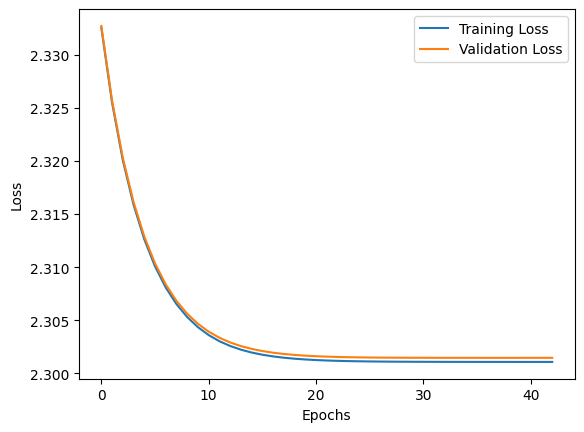

In [18]:
model_leaky_relu_normal = NeuralNetwork(N, A, lr, leaky_relu, leaky_relu_grad, normal_init, epochs, batch_size)
model_leaky_relu_normal.fit(X_train, y_train, X_val, y_val)

print("Metrics for model with Leaky ReLU activation function and normal weight initialization:")
print("Training accuracy:", model_leaky_relu_normal.score(X_train, y_train))
print("Validation accuracy:", model_leaky_relu_normal.score(X_val, y_val))
print("Test accuracy:", model_leaky_relu_normal.score(X_test, y_test))
model_leaky_relu_normal.plot_losses()

# Load saved trained models for evaluation

In [9]:
#load saved models
model_sigmoid_zero = pickle.load(open('b_models/model_sigmoid_zero.pkl', 'rb'))
model_sigmoid_random = pickle.load(open('b_models/model_sigmoid_random.pkl', 'rb'))
model_sigmoid_normal = pickle.load(open('b_models/model_sigmoid_normal.pkl', 'rb'))

model_tanh_zero = pickle.load(open('b_models/model_tanh_zero.pkl', 'rb'))
model_tanh_random = pickle.load(open('b_models/model_tanh_random.pkl', 'rb'))
model_tanh_normal = pickle.load(open('b_models/model_tanh_normal.pkl', 'rb'))

model_relu_zero = pickle.load(open('b_models/model_relu_zero.pkl', 'rb'))
model_relu_random = pickle.load(open('b_models/model_relu_random.pkl', 'rb'))
model_relu_normal = pickle.load(open('b_models/model_relu_normal.pkl', 'rb'))

model_leaky_relu_zero = pickle.load(open('b_models/model_leaky_relu_zero.pkl', 'rb'))
model_leaky_relu_random = pickle.load(open('b_models/model_leaky_relu_random.pkl', 'rb'))
model_leaky_relu_normal = pickle.load(open('b_models/model_leaky_relu_normal.pkl', 'rb'))

#evaluate models
print("Testing Accuracies of the Models:")
print()
print("sigmoid, zero init:", model_sigmoid_zero.score(X_test, y_test))
print("sigmoid, random init:", model_sigmoid_random.score(X_test, y_test))
print("sigmoid, normal init:", model_sigmoid_normal.score(X_test, y_test))
print()
print("tanh, zero init:", model_tanh_zero.score(X_test, y_test))
print("tanh, random init:", model_tanh_random.score(X_test, y_test))
print("tanh, normal init:", model_tanh_normal.score(X_test, y_test))
print()
print("ReLU, zero init:", model_relu_zero.score(X_test, y_test))
print("ReLU, random init:", model_relu_random.score(X_test, y_test))
print("ReLU, normal init:", model_relu_normal.score(X_test, y_test))
print()
print("Leaky ReLU, zero init:", model_leaky_relu_zero.score(X_test, y_test))
print("Leaky ReLU, random init:", model_leaky_relu_random.score(X_test, y_test))
print("Leaky ReLU, normal init:", model_leaky_relu_normal.score(X_test, y_test))

Testing Accuracies of the Models:

sigmoid, zero init: 0.8227
sigmoid, random init: 0.8227
sigmoid, normal init: 0.8227

tanh, zero init: 0.8227
tanh, random init: 0.8227
tanh, normal init: 0.8227

ReLU, zero init: 0.8227
ReLU, random init: 0.8227
ReLU, normal init: 0.8227

Leaky ReLU, zero init: 0.8227
Leaky ReLU, random init: 0.8227
Leaky ReLU, normal init: 0.8227
